# Siamese Networks for classification of Supermarket shelves:

In [36]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle 
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam #
from keras.optimizers import RMSprop #

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate #
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate #
from keras.layers.core import Lambda, Flatten, Dense #
from keras.initializers import glorot_uniform #

from keras.engine.topology import Layer #
from keras.regularizers import l2 #
from keras import backend as K #

from sklearn.utils import shuffle

import numpy.random as rng
import random


ImportError: No module named 'keras.np_utils'

### Load Images

In [2]:
train_data_dir = 'data/train'
w, h = 105, 105

In [3]:
validation_data_dir = 'data/validation'

In [4]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        
        if alphabet.startswith("."):
            continue
        print("loading alphabet: " + alphabet)
        
        lang_dict[alphabet] = curr_y
        alphabet_path = os.path.join(path,alphabet)
        category_images=[]
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            if letter.startswith("."):
                continue
            
            cat_dict[curr_y] = (alphabet, letter)
            
            image_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            image = imread(image_path)
            category_images.append(image)
            y.append(curr_y)
            
        try:
            category_images2 = []
            for shp in category_images:
                tmp = cv2.resize(shp,(w,h))
                category_images2.append(tmp)
        
            X.append(np.stack(category_images2))
            
            # edge case  - last one
        except ValueError as e:
            print(e)
            print("error - category_images:", category_images)
        curr_y += 1
        #lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.vstack(X)
    
    return X, y, lang_dict

In [5]:
X,y,c = loadimgs("data/train")
X_v, y_v,c_v = loadimgs("data/validation")

loading alphabet: Not_Stocked


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Stocked
loading alphabet: Not_Stocked
loading alphabet: Stocked


In [6]:
# 923 images, 105x105, RGB
{"training":X.shape , "validation":X_v.shape}

{'training': (26, 105, 105, 3), 'validation': (21, 105, 105, 3)}

In [7]:
# 923 response, Stocked / Not stocked
{"training":y.shape , "validation":y_v.shape}

{'training': (26, 1), 'validation': (21, 1)}

In [8]:
c

{'Not_Stocked': 0, 'Stocked': 1}

In [9]:
X = X.astype('float32')
X_v = X_v.astype('float32')
X /= 255
X_v /= 255

In [10]:
{"training":X.shape , "validation":X_v.shape}

{'training': (26, 105, 105, 3), 'validation': (21, 105, 105, 3)}

### Set up batch trianing  pairs. 

In [11]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [12]:

def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', 
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', 
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias,
                     kernel_regularizer=l2(2e-4)
                    ))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (1,1), activation='relu', 
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias,
                     kernel_regularizer=l2(2e-4)
                    ))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias
                   ))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',
                       bias_initializer=initialize_bias
                      )(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [13]:
siamese_net = get_siamese_model(input_shape = (w,h,3))

In [14]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         10714688    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

In [15]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [16]:
num_classes = len(set([yi[0] for yi in y]))

### Create pairs for training & validation

In [17]:
digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
digit_indices_v = [np.where(y_v == i)[0] for i in range(num_classes)]

In [18]:
tr_pairs, tr_y = create_pairs(X, digit_indices)
te_pairs, te_y = create_pairs(X_v, digit_indices_v)

In [19]:
tr_pairs.shape

(48, 2, 105, 105, 3)

In [20]:
batch_size = 6
epochs = 20

In [21]:
# train

rms = RMSprop()
#siamese_net.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
optimizer = Adam(lr = 0.001)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['acc'])
#siamese_net.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])
siamese_net.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 48 samples, validate on 36 samples
Epoch 1/20
48/48 [==============================] - 191s 4s/step - loss: 1.3349 - acc: 0.5000 - val_loss: 0.9934 - val_acc: 0.5556
Epoch 2/20
48/48 [==============================] - 193s 4s/step - loss: 0.9464 - acc: 0.4583 - val_loss: 0.7930 - val_acc: 0.6389
Epoch 3/20
48/48 [==============================] - 194s 4s/step - loss: 0.7115 - acc: 0.7708 - val_loss: 0.8200 - val_acc: 0.5833
Epoch 4/20
48/48 [==============================] - 196s 4s/step - loss: 0.7805 - acc: 0.7500 - val_loss: 0.8527 - val_acc: 0.4444
Epoch 5/20
48/48 [==============================] - 196s 4s/step - loss: 0.7606 - acc: 0.6875 - val_loss: 0.8505 - val_acc: 0.5000
Epoch 6/20
48/48 [==============================] - 196s 4s/step - loss: 0.8357 - acc: 0.5000 - val_loss: 0.8149 - val_acc: 0.5000
Epoch 7/20
48/48 [==============================] - 199s 4s/step - loss: 0.7987 - acc: 0.5417 - val_loss: 0.7975 - val_acc: 0.5278
Epoch 8/20
48/48 [=====================

In [23]:
siamese_net2 = get_siamese_model(input_shape = (w,h,3))
rms = RMSprop(lr=0.001)
siamese_net2.compile(loss=contrastive_loss, optimizer=rms, metrics=['acc'])
#optimizer = Adam(lr = 0.001)
#siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['acc'])
#siamese_net.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])
siamese_net.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 48 samples, validate on 36 samples
Epoch 1/20
48/48 [==============================] - 200s 4s/step - loss: 0.6002 - acc: 0.8333 - val_loss: 0.7884 - val_acc: 0.5556
Epoch 2/20
48/48 [==============================] - 196s 4s/step - loss: 0.6212 - acc: 0.7500 - val_loss: 1.0717 - val_acc: 0.5278
Epoch 3/20
48/48 [==============================] - 204s 4s/step - loss: 0.5809 - acc: 0.7500 - val_loss: 0.8048 - val_acc: 0.5556
Epoch 4/20
48/48 [==============================] - 198s 4s/step - loss: 0.5157 - acc: 0.9167 - val_loss: 0.7610 - val_acc: 0.5833
Epoch 5/20
48/48 [==============================] - 197s 4s/step - loss: 0.3728 - acc: 0.9583 - val_loss: 0.8002 - val_acc: 0.6667
Epoch 6/20
48/48 [==============================] - 197s 4s/step - loss: 0.5472 - acc: 0.8333 - val_loss: 0.9462 - val_acc: 0.5000
Epoch 7/20
48/48 [==============================] - 196s 4s/step - loss: 0.6971 - acc: 0.8333 - val_loss: 0.9693 - val_acc: 0.5000
Epoch 8/20
48/48 [=====================

In [24]:
#Saving both models
siamese_net.save_weights("siamese_adam_b_crossentropy.h5")

In [25]:
siamese_net2.save_weights("siamese_rms_contrapositive_loss.h5")

### Model Evaluation

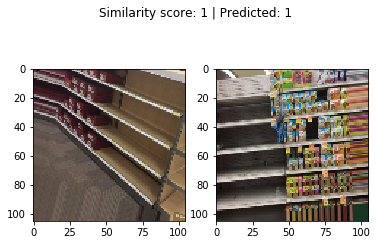

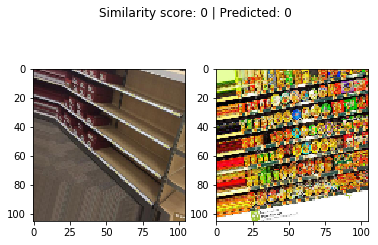

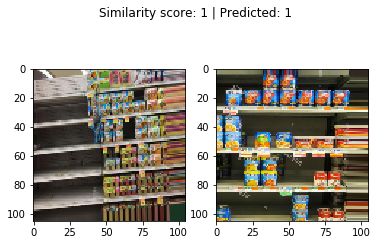

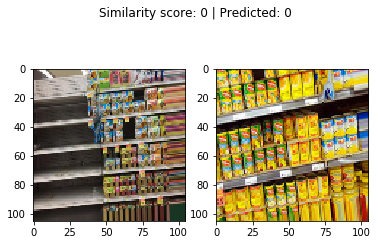

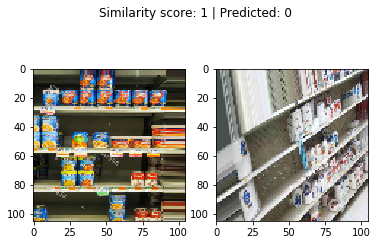

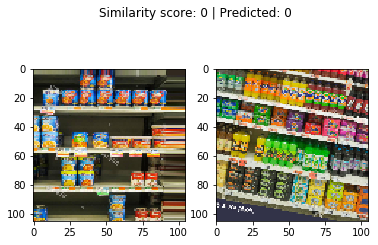

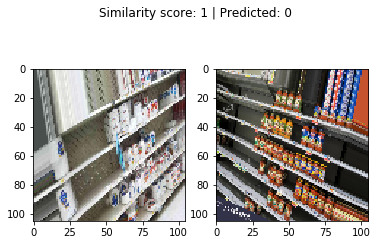

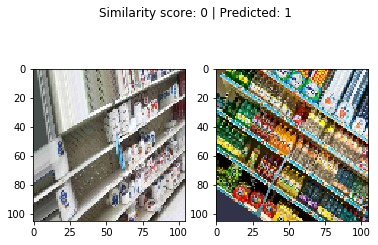

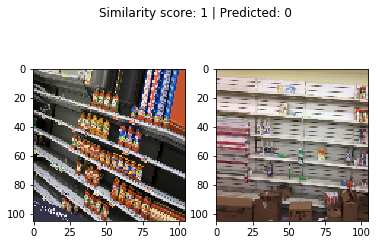

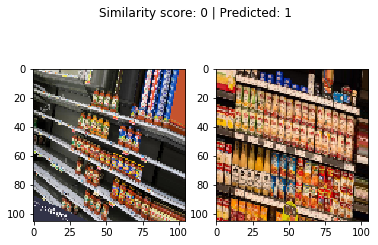

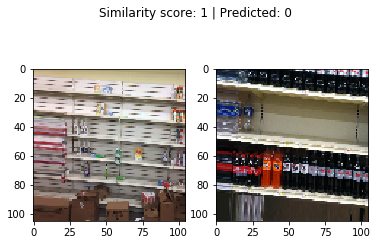

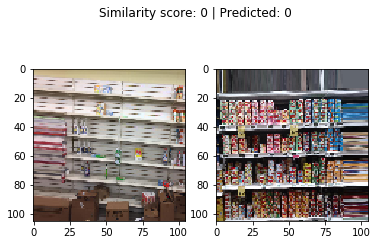

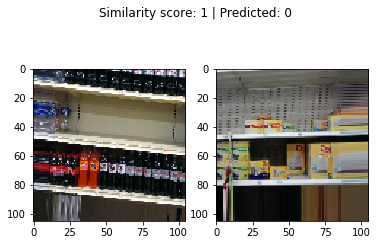

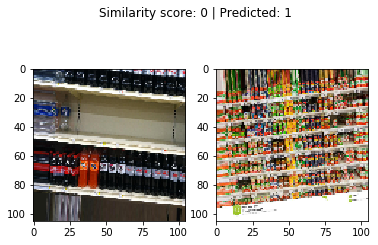

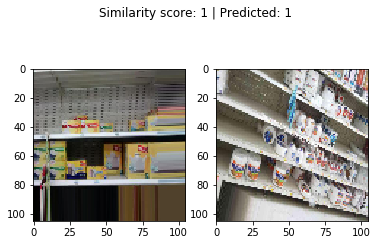

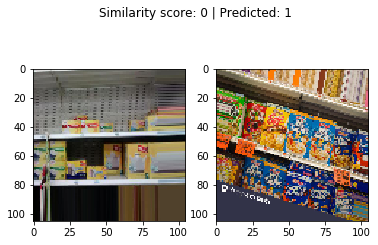

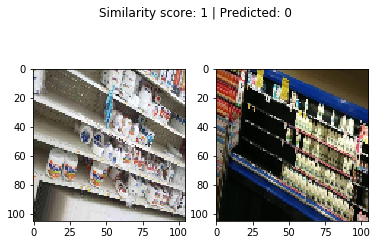

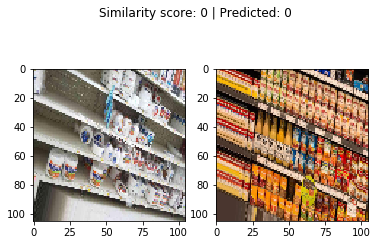

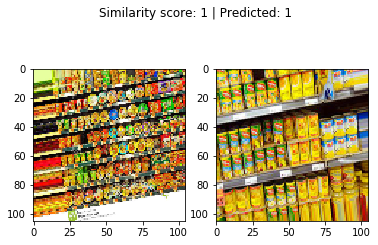

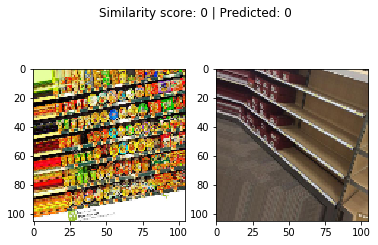

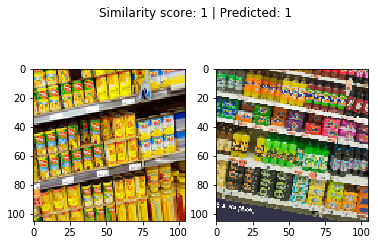

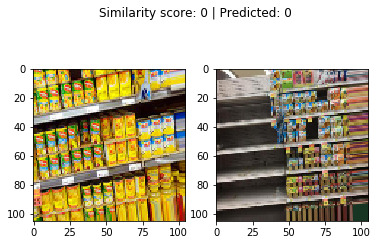

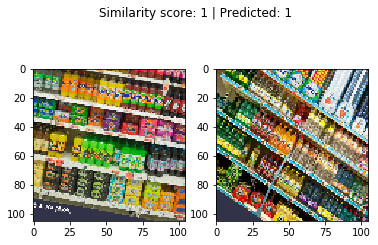

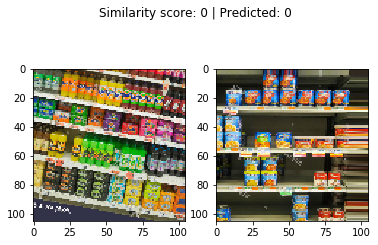

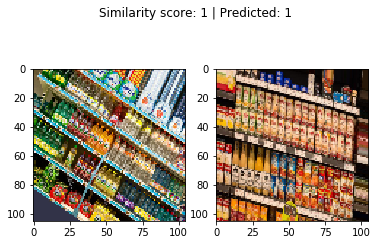

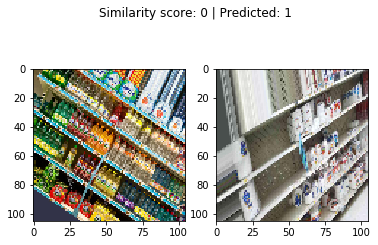

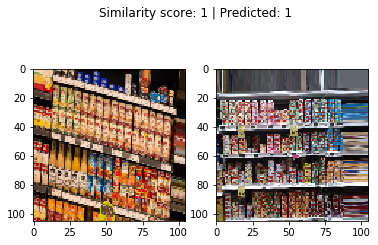

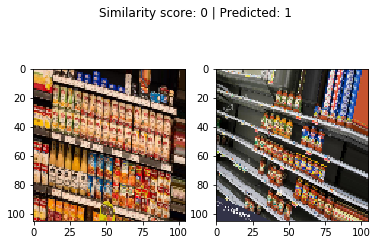

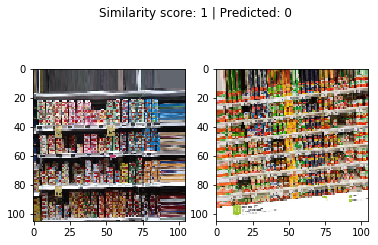

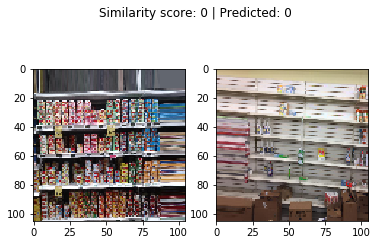

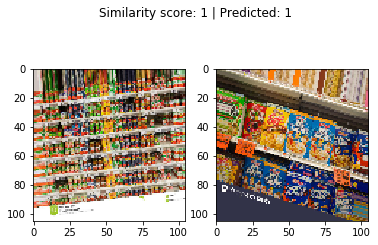

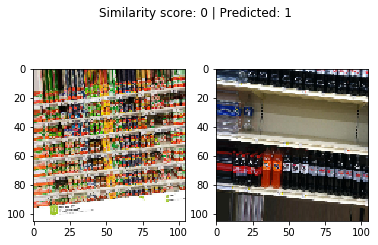

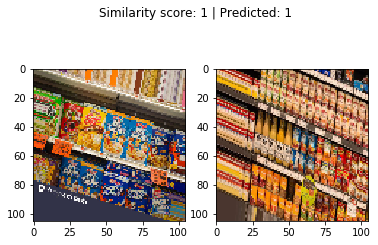

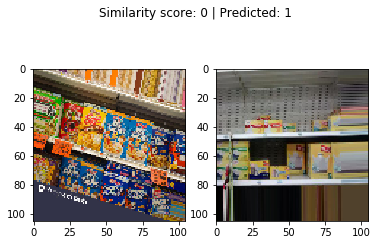

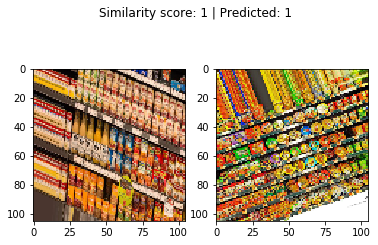

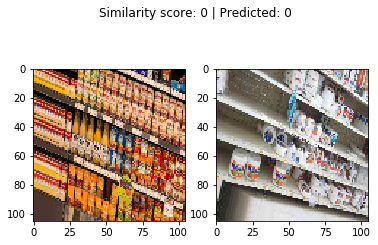

In [55]:
#Training data visualized
indx=0
input1= te_pairs[:, 0]
input2= te_pairs[:, 1]
ynew = siamese_net2.predict([input1, input2])
arb_c = np.mean(ynew)
while indx < len(te_y):
    fig=plt.figure()
    
    ax=fig.add_subplot(1,2,1)        
    ax.imshow(te_pairs[indx, 0])
    ax=fig.add_subplot(1,2,2)        
    ax.imshow(te_pairs[indx, 1])
    if ynew[indx][0] > arb_c:
        pred = "1"
    else:
        pred = "0"
    fig.suptitle("Similarity score: " + str(1- indx%2 ) + " | Predicted: " + pred)
    plt.show()
    indx+=1



Text(0.5,1,'')

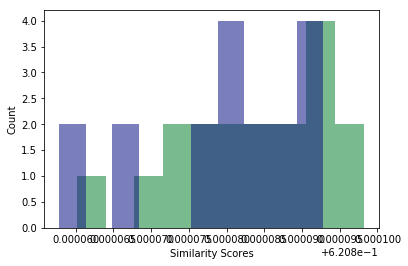

In [53]:

plt.hist(ynew[te_y == 1], color='#1384388f') #green
plt.hist(ynew[te_y == 0], color='#131a848f') #blue
plt.xlabel('Similarity Scores')
plt.ylabel('Count')
plt.title('')


In [ ]:
# This model overfits

In [ ]:
# I think this will fail when comparing same store data.

In [ ]:
# Consider cropping single shelf - mostly stocked vs same shelf fully stocked
# Not touching test set until more tuning is done